<font size="-0.1">

**<center><h1>Exploring Reinforcement Learning Methods to approximate the Lunar Lander problem</h1></center>**
**<center><h2>Advanced Reinforcement Learning Assignment (DQN Experiment)</h2></center>**
**<center><h3>Matthias Bartolo</h3></center>**

</font>

**<h5>Package installation</h5>**

<font size="-0.1">

```pip
conda install swig
conda install nomkl
pip install gymnasium[all]
pip install ufal.pybox2d
pip install pygame
pip install renderlab
pip install numpy
pip install matplotlib
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118/torch_stable.html
```

</font>

**<h5>Package imports</h5>**

In [1]:
import os
import time
import renderlab as rl
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
warnings.filterwarnings("ignore")

# Setting the device to cpu as it was faster than gpu for this task
device = torch.device("cpu")#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("CUDA is available, device is set to {}".format(device))

CUDA is available, device is set to cpu


**<h5>Declaring Hyperparameters</h5>**

In [2]:
# The learning rate α ∈ (0, 1] controls how much we update our current value estimates towards newly received returns.
ALPHA = 0.001
# Gamma refers to the discount factor γ ∈ [0, 1]. It quantifies how much importance is given to future rewards.
GAMMA = 0.99
# The batch size is the number of training examples used in one iteration (that is, one gradient update) of training.
BATCH_SIZE = 128
# The buffer size is the number of transitions stored in the replay buffer, which the agent samples from to learn.
BUFFER_SIZE = 10000
# The minimum replay size is the minimum number of transitions that need to be stored in the replay buffer before the agent starts learning.
MIN_REPLAY_SIZE = 5000
# The maximum replay size is the maximum number of transitions that can be stored in the replay buffer.
MAX_REPLAY_SIZE = 50
# Epsilon start, epsilon end and epsilon decay are the parameters for the epsilon greedy exploration strategy.
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.997
# The target update frequency is the frequency with which the target network is updated.
TARGET_UPDATE_FREQ = 5
# The success criteria is the average reward over the last 50 episodes that the agent must achieve to be considered successful.
SUCCESS_CRITERIA = 195

**<h5>Environment Setup</h5>**

In [3]:
# Creating the "LunarLanderv2" environment from gymnasium
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Resetting the environment
env.reset()

(array([ 0.00517464,  1.4174721 ,  0.52410966,  0.2911814 , -0.00598923,
        -0.11871876,  0.        ,  0.        ], dtype=float32),
 {})

**<h5>Visualising Observation Space</h5>**

In [22]:
# Checking the observation space
obs, info = env.reset()

print("The observation space consists of a Box of shape {}".format(obs.shape))
print('\033[1m' + "The observation space consists of the following values:" + '\033[0m')
print('\033[37m' + 'X position: ' + '\033[0m' + obs[0].astype(str))
print('\033[36m' + 'Y position: ' + '\033[0m' + obs[1].astype(str))
print('\033[35m' + 'X velocity: ' + '\033[0m' + obs[2].astype(str))
print('\033[34m' + 'Y velocity: ' + '\033[0m' + obs[3].astype(str))
print('\033[33m' + 'Angle: ' + '\033[0m' + obs[4].astype(str))
print('\033[32m' + 'Angular velocity: ' + '\033[0m' + obs[5].astype(str))
print('\033[31m' + 'Left leg touching the ground (0 or 1): ' + '\033[0m' + obs[6].astype(str))
print('\033[1m' + 'Right leg touching the ground (0 or 1): ' + '\033[0m' + obs[7].astype(str))

The observation space consists of a Box of shape (8,)
The observation space consists of the following values:
X position: 0.007303429
Y position: 1.403122
X velocity: 0.73974955
Y velocity: -0.34661114
Angle: -0.008456129
Angular velocity: -0.16756436
Left leg touching the ground (0 or 1): 0.0
Right leg touching the ground (0 or 1): 0.0


**<h5>Visualising Action Space</h5>**

In [5]:
def decode_action(action):
    """ Function to decode the action 

        Args:
            action (int): The action to be decoded

    """
    if action == 0:
        print('\033[35m' + "Action: Do nothing" + '\033[0m')
    elif action == 1:
        print('\033[34m' + "Action: Fire left orientation engine" + '\033[0m')
    elif action == 2:
        print('\033[32m' + "Action: Fire main engine" + '\033[0m')
    elif action == 3:
        print('\033[31m' + "Action: Fire right orientation engine" + '\033[0m')

In [6]:
# Checking the action space
action_space = env.action_space
print("The action space is: {}".format(action_space))
print("The number of actions is: {}".format(action_space.n))
print()

# Showing all the possible actions
for i in range(action_space.n):
    decode_action(i)

The action space is: Discrete(4)
The number of actions is: 4

Action: Do nothing
Action: Fire left orientation engine
Action: Fire main engine
Action: Fire right orientation engine


**<h5>Replay Buffer</h5>**

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'done', 'next_state'))

class Replay_Buffer():
    """
        The replay buffer stores the transitions that the agent observes, allowing us to reuse this data later.

        Args:
            env: The environment to interact with
            fullsize: The maximum size of the replay buffer
            minsize: The minimum size of the replay buffer before the agent starts learning
            batchsize: The batch size used for training
    """
    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize) # Using a deque instead of a list for faster appends and pops
        self.rewards = deque(maxlen=MAX_REPLAY_SIZE)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        """ Appends a transition to the replay buffer """
        self.memory.append(transition)

    def sample_batch(self):
        """ Samples a batch of transitions from the replay buffer """
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.state, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.action, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.reward, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.done, dtype=np.bool8)).unsqueeze(1).to(torch.bool)
        next_states = torch.from_numpy(np.array(batch.next_state, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        """ Initializes the replay buffer by sampling transitions from the environment """
        # Resetting the environment
        obs, info = self.env.reset()

        # Sampling transitions until the replay buffer is full
        for _ in range(self.minsize):
            # Sampling a random action
            action = self.env.action_space.sample()

            # Taking a step in the environment
            new_obs, reward, terminated, truncated, info = self.env.step(action)

            # Setting done to terminated or truncated
            done = terminated or truncated

            # Creating a transition
            transition = Transition(obs, action, reward, done, new_obs)

            # Appending the transition to the replay buffer
            self.append(transition)

            # Resetting the observation
            obs = new_obs

            # Resetting the environment if the episode is done
            if done:
                self.env.reset()
        return self

**<h5>DQN Network Class</h5>**

In [5]:
class DQN(nn.Module):
    """
        The DQN network that estimates the action-value function

        Args:
            ninputs: The number of inputs
            noutputs: The number of outputs

        Layers:
            1. Linear layer with 64 neurons
            2. Tanh activation function
            3. Linear layer with noutputs neurons
    """
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, 64)
        self.a2 = nn.Linear(64, noutputs)

    def forward(self, X):
        # Forward pass
        o = self.a1(X)
        o = torch.tanh(o)
        o = self.a2(o)
        return o

    def __call__(self, X):
        return self.forward(X)

**<h5>Dueling DQN Network Class</h5>**

In [6]:
class DuelingDQN(nn.Module):
    """
        The dueling DQN network that estimates the action-value function

        Args:
            ninputs: The number of inputs
            noutputs: The number of outputs

        Layers:
            1. Linear layer with 64 neurons
            2. Tanh activation function
            3. Linear layer with 32 neurons
            4. Linear layer with 1 neuron
            5. Linear layer with 32 neurons
            6. Linear layer with noutputs neurons
    """
    def __init__(self, ninputs, noutputs):
        super(DuelingDQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, 64),
            nn.Tanh(),
            nn.Linear(64, 32)
        )
        # The value function estimates the value of being in a particular state
        self.valfunc = nn.Linear(32, 1)
        # The advantage function estimates how good it is to take a particular action in a given state
        self.advfunc = nn.Linear(32, noutputs)

    def forward(self, X):
        # Forward pass through the network
        o = self.net(X)
        # Splitting the output into the value and advantage functions
        value = self.valfunc(o)
        adv = self.advfunc(o)
        # Returning the value and advantage functions combined into the Q function (Q = V + A - mean(A))
        return value + adv - adv.mean(dim=-1, keepdim=True)

    def __call__(self, X):
        return self.forward(X)

**<h4>DQN Agent Class</h4>**

In [7]:
class DQNAgent():
    """
        The DQN agent that interacts with the environment

        Args:
            env: The environment to interact with
            replay_buffer: The replay buffer to store and sample transitions from
            target_update_freq: The frequency with which the target network is updated
            criterion: The loss function used to train the policy network
            name: The name of the agent (default: DQN)
            network: The network used to estimate the action-value function (default: DQN)

        Attributes:
            env: The environment to interact with
            replay_buffer: The replay buffer to store and sample transitions from
            nsteps: The number of steps to run the agent for
            target_update_freq: The frequency with which the target network is updated
            ninputs: The number of inputs
            noutputs: The number of outputs
            policy_net: The policy network
            target_net: The target network
            optimizer: The optimizer used to update the policy network
            criterion: The loss function used to train the policy network
            epsilon: The probability of selecting a random action
            steps_done: The number of steps the agent has run for
            episodes: The number of episodes the agent has run for
            episode_avg_rewards: The average reward for each episode
            episode_lengths: The lengths of each episode
            best_episode: The best episode
            solved: Whether the environment is solved
            display_every_n_episodes: The number of episodes after which the results are displayed
            time: The time taken to run the agent
    """
    def __init__(self, env, replay_buffer, target_update_freq, criterion=nn.SmoothL1Loss(), name="DQN", network=DQN):
        self.env = env
        self.replay_buffer = replay_buffer
        self.target_update_freq = target_update_freq
        self.ninputs = env.observation_space.shape[0]
        self.noutputs = env.action_space.n
        self.policy_net = network(self.ninputs, self.noutputs).to(device)
        self.target_net = network(self.ninputs, self.noutputs).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=ALPHA)
        self.criterion = criterion
        self.epsilon = EPS_START
        self.steps_done = 0
        self.episodes = 0
        self.episode_info = {"name":name, "episode_avg_rewards": [], "episode_lengths": [], "best_episode": {"episode": 0, "avg_reward": np.NINF}, "solved": False, "eps_duration": 0}
        self.display_every_n_episodes = 100

    def select_action(self, state):
        """ Selects an action using an epsilon greedy policy """
        # Selecting a random action with probability epsilon
        if random.random() <= self.epsilon: # Exploration
            action = self.env.action_space.sample()
        else: # Exploitation
            # Selecting the action with the highest Q-value otherwise
            with torch.no_grad():
                state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                qvalues = self.policy_net(state)
                action = qvalues.argmax().item()
        return action
        
    def update(self):
        """ Updates the policy network using a batch of transitions """
        # Sampling a batch of transitions from the replay buffer
        states, actions, rewards, dones, next_states = self.replay_buffer.sample_batch()

        # Converting the tensors to cuda tensors
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        dones = dones.to(device)
        next_states = next_states.to(device)
        
        # Calculating the Q-values for the current states
        qvalues = self.policy_net(states).gather(1, actions)
        
        # Calculating the Q-values for the next states
        with torch.no_grad():
            # Calculating the Q-values for the next states using the target network (Q(s',a'))
            target_qvalues = self.target_net(next_states)

            # Calculating the maximum Q-values for the next states (max(Q(s',a'))
            max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)

            # Calculating the next Q-values using the Bellman equation (Q(s,a) = r + γ * max(Q(s',a')))
            next_qvalues = rewards + GAMMA * (1 - dones.type(torch.float32)) * max_target_qvalues

        # Calculating the loss
        loss = self.criterion(qvalues, next_qvalues)

        # Optimizing the model
        self.optimizer.zero_grad()
        loss.backward()

        # Clipping the gradients
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # Updating the target network
        if self.episodes % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            

    def update_epsilon(self):
        """ Updates epsilon """
        self.epsilon = max(EPS_END, EPS_DECAY * self.epsilon)

    def train(self):
        """ Trains the agent for nsteps steps """
        # Resetting the environment
        obs, _ = self.env.reset()

        # Retrieving the starting time
        start_time = time.time()

        # Setting the episode_reward to 0
        episode_reward = 0

        # Running the agent for nsteps steps
        for step in itertools.count():
            # Selecting an action
            action = self.select_action(obs)

            # Taking a step in the environment
            new_obs, reward, terminated, truncated, _ = self.env.step(action)

            # Adding the reward to the cumulative reward
            episode_reward += reward

            # Setting done to terminated or truncated
            done = terminated or truncated

            # Creating a transition
            transition = Transition(obs, action, reward, done, new_obs)

            # Appending the transition to the replay buffer
            self.replay_buffer.append(transition)

            # Resetting the observation
            obs = new_obs

            # Ending the episode and displaying the results if the episode is done
            if done:
                # Appending the rewards to the replay buffer
                self.replay_buffer.rewards.append(episode_reward)

                # Updating epsilon
                self.update_epsilon()

                # Resetting the environment
                obs, _ = self.env.reset()

                # Incrementing the number of episodes
                self.episodes += 1

                # Appending the average episode reward
                self.episode_info["episode_avg_rewards"].append(np.mean(self.replay_buffer.rewards))

                # Appending the episode length
                self.episode_info["episode_lengths"].append(self.steps_done)

                # Updating the best episode
                if self.episode_info["episode_avg_rewards"][-1] > self.episode_info["best_episode"]["avg_reward"]:
                    self.episode_info["best_episode"]["episode"] = self.episodes
                    self.episode_info["best_episode"]["avg_reward"] = self.episode_info["episode_avg_rewards"][-1]

                # Checking if the environment is solved
                if np.mean(self.episode_info["episode_avg_rewards"][-MAX_REPLAY_SIZE:]) >= SUCCESS_CRITERIA:
                    self.episode_info["solved"] = True

                # Checking if the environment is solved
                if self.episode_info["solved"]:
                    print("\033[32mSolved in {} episodes!\033[0m".format(self.episodes))
                    print("-" * 100)
                    break
                
                # Displaying the results
                if self.episodes % self.display_every_n_episodes == 0:
                    print("\033[35mEpisode:\033[0m {} \033[35mEpsilon:\033[0m {:.2f} \033[35mAverage Reward:\033[0m {} \033[35mEpisode Length:\033[0m {}".format(
                                self.episodes,
                                self.epsilon,
                                self.episode_info["episode_avg_rewards"][-1],
                                self.episode_info["episode_lengths"][-1])
                        )
                    print("-" * 100)

                # Resetting the cumulative reward
                episode_reward = 0

            # Updating the policy network
            self.update()

            # Updating the number of steps
            self.steps_done += 1

        # Retrieving the ending time
        end_time = time.time()

        # Calculating the time taken
        self.episode_info["eps_duration"] = end_time - start_time

    def run(self):
        """ Runs the agent """
        # Initializing the replay buffer
        self.replay_buffer.initialize()

        # Training the agent
        self.train()


    def test(self):
        """ Tests the trained agent """
        # Resetting the environment
        obs, _ = self.env.reset()

        # Playing the environment
        while True:
            # Selecting the action with the highest Q-value
            action = int(torch.argmax(self.policy_net(torch.from_numpy(obs).float().unsqueeze(0).to(device))).item())

            # Taking a step in the environment
            obs, _, terminated, truncated, _ = self.env.step(action)

            # Setting done to terminated or truncated
            if terminated or truncated:
                break
        
        # Playing the video
        self.env.play()


    def save(self, path="models/dqn"):
        """ Function to save the model 
            
            Args:
                path (str): The path to save the model to
        """
        # Creating the directory if it does not exist
        if not os.path.exists(path):
            os.makedirs(path)

        # Saving the model
        torch.save(self.policy_net.state_dict(), path + "/policy_net.pth")
        torch.save(self.target_net.state_dict(), path + "/target_net.pth")

        # Saving the episode info
        np.save(path + "/episode_info.npy", self.episode_info)

    def load(self, path="models/dqn"):
        """ Function to load the model 
            
            Args:
                path (str): The path to load the model from
        """
        # Loading the model
        self.policy_net.load_state_dict(torch.load(path + "/policy_net.pth"))
        self.target_net.load_state_dict(torch.load(path + "/target_net.pth"))

        # Loading the episode info
        self.episode_info = np.load(path + "/episode_info.npy", allow_pickle=True).item()

    def get_episode_info(self):
        """ Returns the episode info """
        return self.episode_info

**<h4>Double DQN Agent Class</h4>**

In [8]:
class DoubleDQNAgent(DQNAgent):
    """ The Double DQN agent that interacts with the environment and inherits from the DQN agent """
    def __init__(self, env, replay_buffer, target_update_freq, criterion=nn.SmoothL1Loss(), name="DoubleDQN"):
        super().__init__(env, replay_buffer, target_update_freq, criterion, name, DQN)

    def update(self):
        """ Updates the policy network using a batch of transitions """
        # Sampling a batch of transitions from the replay buffer
        states, actions, rewards, dones, next_states = self.replay_buffer.sample_batch()

        # Converting the tensors to cuda tensors
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        dones = dones.to(device)
        next_states = next_states.to(device)
        
        # Calculating the Q-values for the current states
        qvalues = self.policy_net(states).gather(1, actions)

        # Calculating the Q-values for the next states
        with torch.no_grad():
            # Using the policy network to select the action with the highest Q-value for the next states (argmax(Q(s',a)))
            next_state_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
            
            # Using the target network to calculate the Q-value of the selected action for the next states (Q'(s',argmax(Q(s',a))))
            next_qvalues = self.target_net(next_states).gather(1, next_state_actions)

            # Calculating the next Q-values using the Bellman equation (Q(s,a) = r + γ * Q'(s',argmax(Q(s',a))))
            target_qvalues = rewards + GAMMA * (1 - dones.type(torch.float32)) * next_qvalues

        # Calculating the loss
        loss = self.criterion(qvalues, target_qvalues)

        # Optimizing the model
        self.optimizer.zero_grad()
        loss.backward()

        # Clipping the gradients
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # Updating the target network
        if self.episodes % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

**<h4>Dueling DQN Agent Class</h4>**

In [9]:
class DuelingDQNAgent(DQNAgent):
    """ The Dueling DQN agent that interacts with the environment and inherits from the DQN agent """
    def __init__(self, env, replay_buffer, target_update_freq, criterion=nn.SmoothL1Loss(), name="DuelingDQN"):
        super().__init__(env, replay_buffer, target_update_freq, criterion, name, DuelingDQN)

**<h4>Double Dueling DQN Agent Class</h4>**

In [10]:
class DoubleDuelingDQNAgent(DQNAgent):
    """ The Double Dueling DQN agent that interacts with the environment and inherits from the DQN agent """
    def __init__(self, env, replay_buffer, target_update_freq, criterion=nn.SmoothL1Loss(), name="DoubleDuelingDQN"):
        super().__init__(env, replay_buffer, target_update_freq, criterion, name, DuelingDQN)

    def update(self):
        """ Updates the policy network using a batch of transitions """
        # Sampling a batch of transitions from the replay buffer
        states, actions, rewards, dones, next_states = self.replay_buffer.sample_batch()

        # Converting the tensors to cuda tensors
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        dones = dones.to(device)
        next_states = next_states.to(device)
        
        # Calculating the Q-values for the current states
        qvalues = self.policy_net(states).gather(1, actions)

        # Calculating the Q-values for the next states
        with torch.no_grad():
            # Using the policy network to select the action with the highest Q-value for the next states (argmax(Q(s',a)))
            next_state_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
            
            # Using the target network to calculate the Q-value of the selected action for the next states (Q'(s',argmax(Q(s',a))))
            next_qvalues = self.target_net(next_states).gather(1, next_state_actions)

            # Calculating the next Q-values using the Bellman equation (Q(s,a) = r + γ * Q'(s',argmax(Q(s',a))))
            target_qvalues = rewards + GAMMA * (1 - dones.type(torch.float32)) * next_qvalues

        # Calculating the loss
        loss = self.criterion(qvalues, target_qvalues)

        # Optimizing the model
        self.optimizer.zero_grad()
        loss.backward()

        # Clipping the gradients
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        # Updating the target network
        if self.episodes % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

**<h5>Training Normal DQN Agent</h5>**

In [15]:
# Setting name
name = "Normal DQN"

# Creating the Replay_Buffer
replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# Creating the DQN agent
dqn_agent = DQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# Running the agent
dqn_agent.run()

# Retrieving the episode info
dqn_episode_info = dqn_agent.get_episode_info()

# Printing the time taken to train the agent
print("Time taken to train the agent: {:.2f} seconds".format(dqn_episode_info["eps_duration"]))

# Saving the model
dqn_agent.save(path="models/" + name)

Episode: 100 Epsilon: 0.67 Average Reward: -86.40943021637403 Episode Length: 10578
----------------------------------------------------------------------------------------------------
Episode: 200 Epsilon: 0.49 Average Reward: -29.79430708454042 Episode Length: 26969
----------------------------------------------------------------------------------------------------
Episode: 300 Epsilon: 0.37 Average Reward: -18.82979191508714 Episode Length: 48938
----------------------------------------------------------------------------------------------------
Episode: 400 Epsilon: 0.27 Average Reward: 29.108110566349715 Episode Length: 98477
----------------------------------------------------------------------------------------------------
Episode: 500 Epsilon: 0.20 Average Reward: 90.41613133785171 Episode Length: 162293
----------------------------------------------------------------------------------------------------
Episode: 600 Epsilon: 0.15 Average Reward: 99.6751957984914 Episode Length:

**<h5>Training Double DQN Agent</h5>**

In [18]:
# Setting name
name = "Double DQN"

# Creating the Replay_Buffer
del replay_buffer
replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# Creating the DQN agent
double_dqn_agent = DoubleDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# Running the agent
double_dqn_agent.run()

# Retrieving the episode info
double_dqn_episode_info = double_dqn_agent.get_episode_info()

# Printing the time taken to train the agent
print("Time taken to train the agent: {:.2f} seconds".format(double_dqn_episode_info["eps_duration"]))

# Saving the model
double_dqn_agent.save(path="models/" + name)

Episode: 100 Epsilon: 0.67 Average Reward: -74.8779891047147 Episode Length: 10718
----------------------------------------------------------------------------------------------------
Episode: 200 Epsilon: 0.49 Average Reward: -33.5583925089075 Episode Length: 25048
----------------------------------------------------------------------------------------------------
Episode: 300 Epsilon: 0.37 Average Reward: 29.117098341306296 Episode Length: 59139
----------------------------------------------------------------------------------------------------
Episode: 400 Epsilon: 0.27 Average Reward: 66.18076325315792 Episode Length: 118498
----------------------------------------------------------------------------------------------------
Episode: 500 Epsilon: 0.20 Average Reward: 131.0698334685858 Episode Length: 183271
----------------------------------------------------------------------------------------------------
Episode: 600 Epsilon: 0.15 Average Reward: 131.15730487554717 Episode Length:

**<h5>Training Dueling DQN Agent</h5>**

In [21]:
# Setting name
name = "Dueling DQN"

# Creating the Replay_Buffer
del replay_buffer
replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# Creating the DQN agent
dueling_dqn_agent = DuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# Running the agent
dueling_dqn_agent.run()

# Retrieving the episode info
dueling_dqn_episode_info = dueling_dqn_agent.get_episode_info()

# Printing the time taken to train the agent
print("Time taken to train the agent: {:.2f} seconds".format(dueling_dqn_episode_info["eps_duration"]))

# Saving the model
dueling_dqn_agent.save(path="models/" + name)

Episode: 100 Epsilon: 0.67 Average Reward: -73.72714267958185 Episode Length: 10442
----------------------------------------------------------------------------------------------------
Episode: 200 Epsilon: 0.49 Average Reward: -36.26303043426494 Episode Length: 26534
----------------------------------------------------------------------------------------------------
Episode: 300 Epsilon: 0.37 Average Reward: -14.944419937130874 Episode Length: 57764
----------------------------------------------------------------------------------------------------
Episode: 400 Epsilon: 0.27 Average Reward: 15.992019624054164 Episode Length: 107473
----------------------------------------------------------------------------------------------------
Episode: 500 Epsilon: 0.20 Average Reward: 140.84105808412426 Episode Length: 161984
----------------------------------------------------------------------------------------------------
Episode: 600 Epsilon: 0.15 Average Reward: 220.38779418743184 Episode Le

**<h5>Training Double Dueling DQN Agent</h5>**

In [44]:
# Setting name
name = "Double Dueling DQN"

# Creating the Replay_Buffer
del replay_buffer
replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# Creating the DQN agent
double_dueling_dqn_agent = DoubleDuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name=name)

# Running the agent
double_dueling_dqn_agent.run()

# Retrieving the episode info
double_dueling_dqn_episode_info = double_dueling_dqn_agent.get_episode_info()

# Printing the time taken to train the agent
print("Time taken to train the agent: {:.2f} seconds".format(double_dueling_dqn_episode_info["eps_duration"]))

# Saving the model
double_dueling_dqn_agent.save(path="models/" + name)

Episode: 100 Epsilon: 0.67 Average Reward: -75.47795517142045 Episode Length: 11203
----------------------------------------------------------------------------------------------------
Episode: 200 Epsilon: 0.49 Average Reward: -38.533548788454674 Episode Length: 24447
----------------------------------------------------------------------------------------------------
Episode: 300 Epsilon: 0.37 Average Reward: 26.453101001655437 Episode Length: 52778
----------------------------------------------------------------------------------------------------
Episode: 400 Epsilon: 0.27 Average Reward: 82.6044103359546 Episode Length: 104927
----------------------------------------------------------------------------------------------------
Episode: 500 Epsilon: 0.20 Average Reward: 108.12122681211699 Episode Length: 167174
----------------------------------------------------------------------------------------------------
Episode: 600 Epsilon: 0.15 Average Reward: 154.9145143265292 Episode Lengt

**<h5>Testing</h5>**

In [14]:
import renderlab as rl

# Setting renderlab
env = rl.RenderFrame(env, "./video")

In [17]:
replay_buffer = Replay_Buffer(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE)

# Creating agents
dqn_agent = DQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name="DQN")
double_dqn_agent = DoubleDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name="Double DQN")
dueling_dqn_agent = DuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name="Dueling DQN")
double_dueling_dqn_agent = DoubleDuelingDQNAgent(env, replay_buffer, TARGET_UPDATE_FREQ, name="Double Dueling DQN")

In [18]:
# Loading models
dqn_agent.load(path="models/Normal DQN")
double_dqn_agent.load(path="models/Double DQN")
dueling_dqn_agent.load(path="models/Dueling DQN")
double_dueling_dqn_agent.load(path="models/Double Dueling DQN")

In [19]:
dqn_agent.test()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [20]:
double_dqn_agent.test()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [21]:
dueling_dqn_agent.test()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !


Moviepy - video ready temp-{start}.mp4


In [22]:
double_dueling_dqn_agent.test()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


**<h5>Function to plot the results</h5>**

In [20]:
def display(episode_infos, episode_colors=["blue", "orange", "purple", "cyan", "lightgreen"], alpha=0.5, do_save=False, save_path="dqn_results/"):
    """ Function to display the results of the training between multiple agents

        Args:
            episode_infos (list): List of episode info dictionaries to display
            episode_colors (list): The colors to use for the plots
            alpha (float): The alpha value for the plots
            do_save (bool): Whether to save the plots
            save_path (str): The path to save the plots to
    """
    # Plotting Average Rewards
    plt.figure(figsize=(10, 7))
    plt.title("Average Rewards per Episode during Training", fontsize=18)
    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("Values", fontsize=14)
    
    # Iterating through the episode infos to plot the average rewards
    for i, episode_info in enumerate(episode_infos):
        # Generating random marker color such that it is different from the previous one
        marker_color = np.random.rand(3,)
        if i == 0:
            plt.axhline(y=SUCCESS_CRITERIA, color='r', linestyle='--', label="Success Criteria")

        # Plotting the average rewards
        plt.plot(episode_info["episode_avg_rewards"], color=episode_colors[i % len(episode_colors)], label="{}".format(episode_infos[i]["name"]))
        plt.plot(episode_info["best_episode"]["episode"], episode_info["best_episode"]["avg_reward"], marker='o', markersize=8, color=marker_color, linestyle='', label="{} Best Episode {}".format(episode_infos[i]["name"], episode_info["best_episode"]["episode"]))

    plt.grid(alpha=alpha)
    plt.legend(loc='lower right')

    # Saving the plot
    if do_save:
        # Creating the directory if it does not exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        plt.savefig(save_path + "avg_rewards.png")
    else:
        plt.show()

    # Plotting Episode Lengths
    plt.figure(figsize=(10, 7))
    plt.title("Episode Lengths per Episode during Training", fontsize=18)
    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("Values", fontsize=14)
    
    # Iterating through the episode infos to plot the episode lengths
    for i, episode_info in enumerate(episode_infos):
        # Generating random marker color such that it is different from the previous one
        marker_color = np.random.rand(3,)

        plt.plot(episode_info["episode_lengths"], color=episode_colors[i % len(episode_colors)], label="{}".format(episode_infos[i]["name"]))
        plt.plot(episode_info["best_episode"]["episode"], episode_info["episode_lengths"][episode_info["best_episode"]["episode"]-1], marker='o', markersize=8, linestyle='', color=marker_color, label="{} Best Episode {}".format(episode_infos[i]["name"], episode_info["best_episode"]["episode"]))

    plt.grid(alpha=alpha)
    plt.legend(loc='lower right')
    
    # Saving the plot
    if do_save:
        plt.savefig(save_path + "episode_lengths.png")
    else:
        plt.show()

    # Creating a list of names
    names = [episode_info["name"] for episode_info in episode_infos]

    # Plotting Episode Duration
    plt.figure(figsize=(10, 7))
    plt.title("Training Time", fontsize=18)
    plt.xlabel("Agents", fontsize=14)
    plt.ylabel("Duration (s)", fontsize=14)
    plt.xticks(range(len(names)), names, rotation=45)
    
    # Iterating through the episode infos to plot the episode durations
    for i, episode_info in enumerate(episode_infos):      
        plt.bar(i, episode_info["eps_duration"], color=episode_colors[i % len(episode_colors)], label="{}".format(episode_infos[i]["name"]))
        plt.text(i, episode_info["eps_duration"] + 0.01, "{:.2f}s".format(episode_info["eps_duration"]), ha='center', va='bottom', color=episode_colors[i % len(episode_colors)])
    plt.legend(loc='lower right')

    # Saving the plot
    if do_save:
        plt.savefig(save_path + "training_time.png")
    else:
        plt.show()

    # Plotting the maximum episode average rewards for each agent
    plt.figure(figsize=(10, 7))
    plt.title("Maximum Episode Average Rewards", fontsize=18)
    plt.xlabel("Agents", fontsize=14)
    plt.ylabel("Values", fontsize=14)
    plt.xticks(range(len(names)), names, rotation=45)

    # Iterating through the episode infos to plot the maximum episode average rewards
    for i, episode_info in enumerate(episode_infos):
        plt.bar(i, episode_info["best_episode"]["avg_reward"], color=episode_colors[i % len(episode_colors)], label="{}".format(episode_infos[i]["name"]))
        plt.text(i, episode_info["best_episode"]["avg_reward"] + 0.01, "{:.2f}".format(episode_info["best_episode"]["avg_reward"]), ha='center', va='bottom', color=episode_colors[i % len(episode_colors)])
    plt.legend(loc='lower right')

    # Saving the plot
    if do_save:
        plt.savefig(save_path + "max_episode_avg_rewards.png")
    else:
        plt.show()

**<h5>Comparing the results</h5>**

In [12]:
# Loading the episode infos
dqn_episode_info = np.load("models/Normal DQN/episode_info.npy", allow_pickle=True).item()
double_dqn_episode_info = np.load("models/Double DQN/episode_info.npy", allow_pickle=True).item()
dueling_dqn_episode_info = np.load("models/Dueling DQN/episode_info.npy", allow_pickle=True).item()
double_dueling_dqn_episode_info = np.load("models/Double Dueling DQN/episode_info.npy", allow_pickle=True).item()

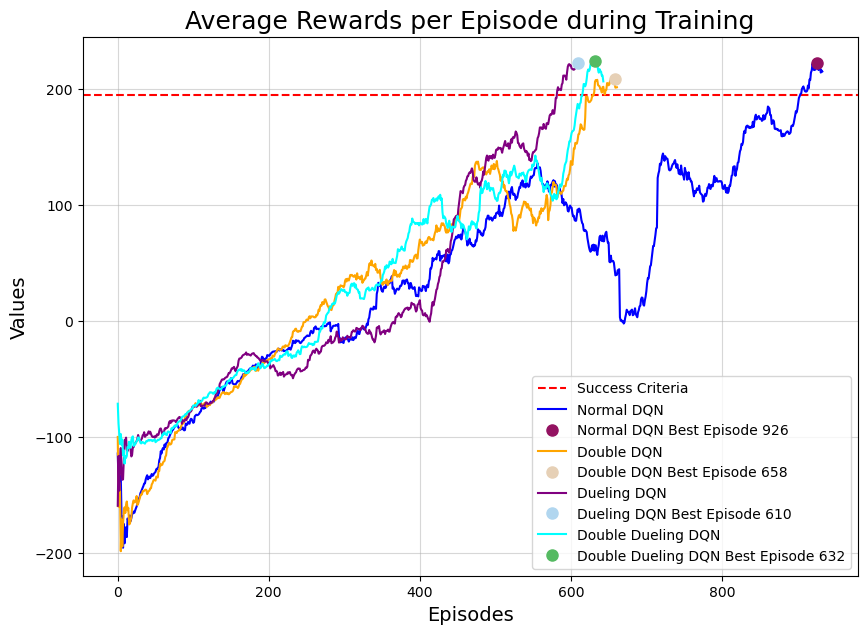

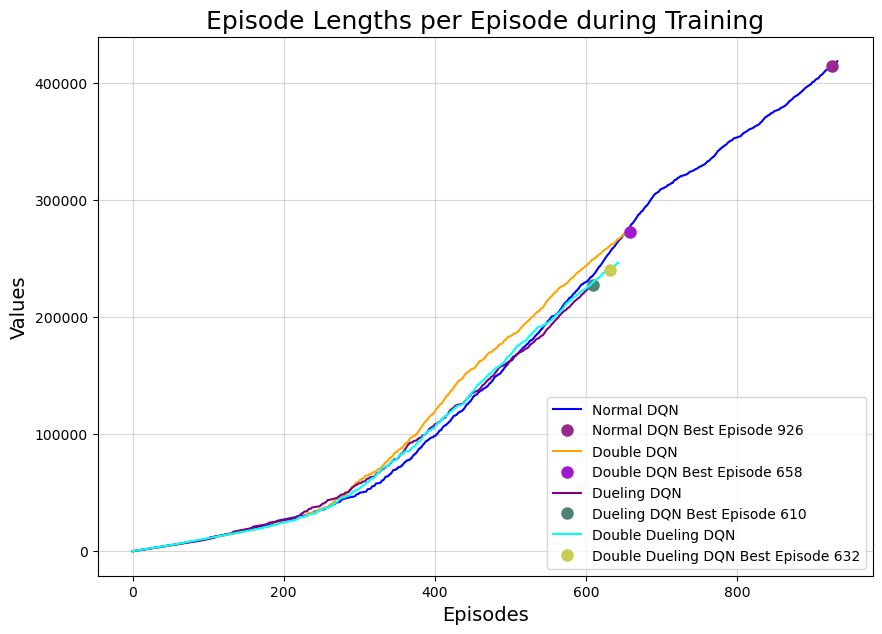

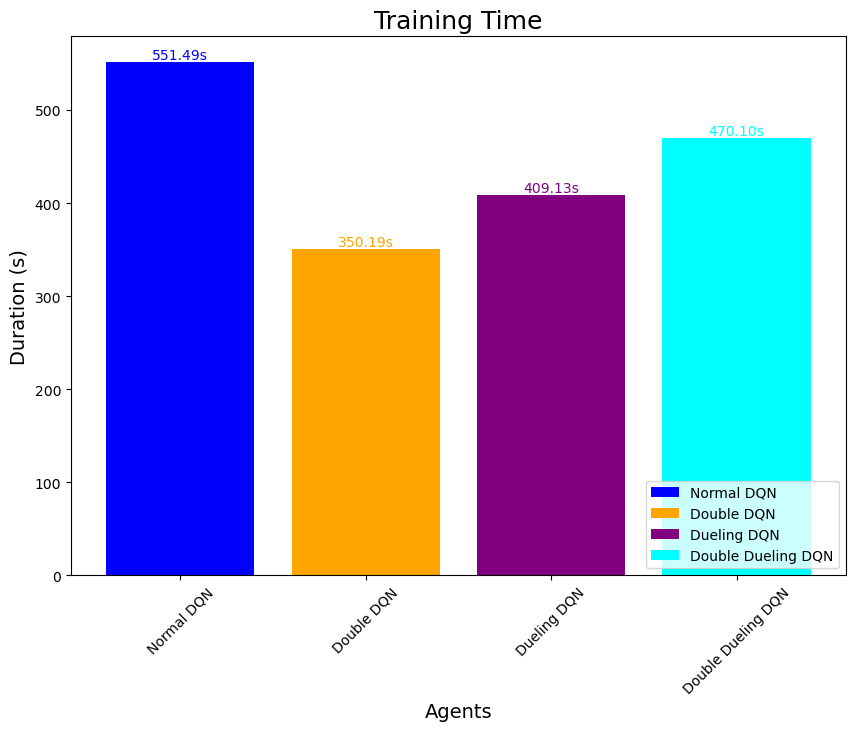

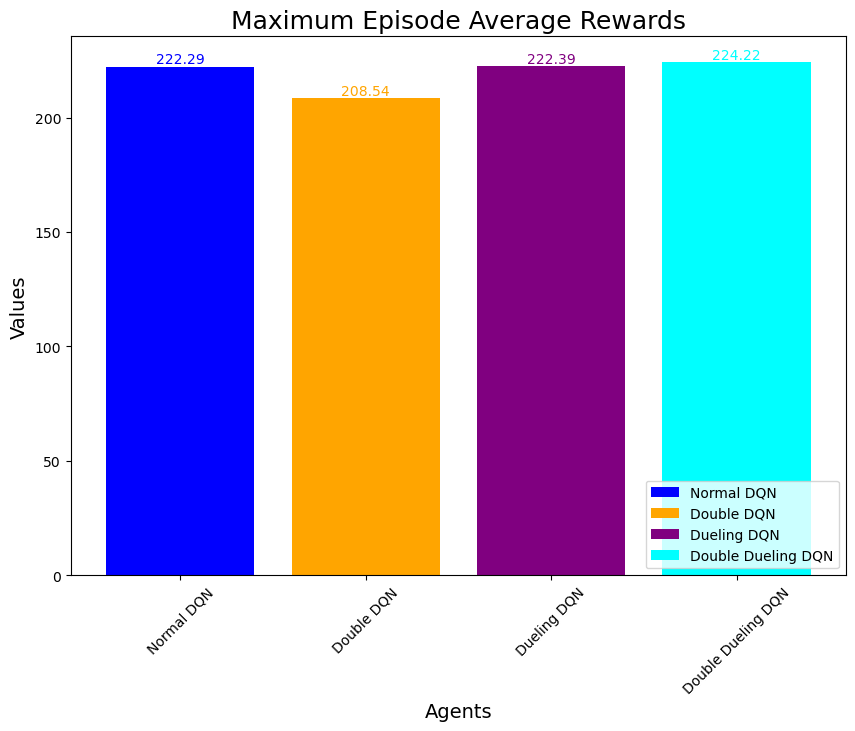

In [21]:
# Creating the episode info list
episode_info = [dqn_episode_info, double_dqn_episode_info, dueling_dqn_episode_info, double_dueling_dqn_episode_info]

display(episode_info, do_save=True, save_path="dqn_results/")

**<h5>Closing the environment</h5>**

In [23]:
env.close()